In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
import os 
import numpy as np 

from functions_data import binarise_using_max, import_data, shuffle_data, convert_df_to_tensor

In [87]:
def separate_train_test_data(binary_data, students_separation_point, questions_separation_point):
    test = binary_data[students_separation_point:, questions_separation_point:]
    train_1 = binary_data[:students_separation_point, questions_separation_point:]
    train_2 = binary_data[students_separation_point:, :questions_separation_point]

    assert (train_2.shape == test.shape)

    return train_1, train_2, test





def zeros_ones_data(binary_data):
    bin_avg_frac = binary_data.values.sum() / binary_data.size * 100
    print('Fraction of ones in the binary dataset is ',
          "{0:0.2f}".format(bin_avg_frac), "%")


def MLE_estimator(binary_train_data):
    learning_rate = 0.0003
    n_students = binary_train_data.shape[0]
    n_questions = binary_train_data.shape[1]

    NLL = 0
    NLLs = []
    dtype = torch.FloatTensor
    seed_number = 1000
    rng = torch.Generator()
    rng.manual_seed(seed_number)
    Bs = torch.randn(n_students, requires_grad=True, generator=rng)
    Bq = torch.randn(n_questions, requires_grad=True, generator=rng)

    for iter in range(3500):
        Bs_matrix = Bs.repeat(n_questions, 1)
        Bs_matrix = torch.transpose(Bs_matrix, 0, 1)
        Bq_matrix = Bq.repeat(n_students, 1)

        probit_1 = torch.log(1 / (1 + torch.exp(-Bs_matrix - Bq_matrix)))
        probit_0 = torch.log(1 / (1 + torch.exp(+Bs_matrix + Bq_matrix)))
        NLL = -torch.sum(binary_train_data * probit_1 + (1 - binary_train_data) * probit_0)

        probit_1 = torch.log(1 / (1 + torch.exp(-Bs_matrix - Bq_matrix)))
        probit_0 = torch.log(1 / (1 + torch.exp(+Bs_matrix + Bq_matrix)))
        NLL = -torch.sum(binary_train_data * probit_1 + (1 - binary_train_data) * probit_0)

        NLL.backward()

        Bs.data -= learning_rate * Bs.grad.data
        Bq.data -= learning_rate * Bq.grad.data

        # Manually zero the gradients after updating weights
        Bs.grad.data.zero_()
        Bq.grad.data.zero_()

        NLLs.append(NLL.detach().numpy())

    # plt.plot(NLLs)
    # plt.xlabel('Iteration of the maximum likelihood algorithm')
    # plt.ylabel('Negative log likelihood')
    # plt.show()
    return Bs, Bq, NLLs 


def test_MLE(test_data, Bs_est, Bq_est):
    n_students = test_data.shape[0]
    n_questions = test_data.shape[1]
    predictions = torch.zeros_like(test_data).t()

    predictions += Bq_est.detach().repeat(n_students, 1).t()
    predictions += Bs_est.detach().repeat(n_questions, 1)

    predictions = predictions.t()

    m = nn.Sigmoid()

    sigmoid = m(predictions)
    
    predictions = torch.bernoulli(sigmoid)

    accuracy = torch.count_nonzero(predictions == test_data)

    return accuracy / (n_students * n_questions), sigmoid 



def real_data_experiments(binarised_data):

    df = convert_df_to_tensor(binarised_data)

    # df = df[:500, :]
    n_s = df.shape[0]
    n_q = df.shape[1]
    students_separation_point = n_s // 2
    questions_separation_point = n_q // 2

    train_1, train_2, test = separate_train_test_data(df, students_separation_point,
                                                      questions_separation_point)

    Bs_estimated_1, Bq_estimated_1 = MLE_estimator(train_1)
    Bs_estimated_2, Bq_estimated_2 = MLE_estimator(train_2)

    Bs_estimated = Bs_estimated_1 + Bs_estimated_2
    Bq_estimated = Bq_estimated_2 + Bq_estimated_1

    acc, predictions = test_MLE(test, Bs_estimated_2, Bq_estimated_1)
    print(acc)

In [88]:
data_file = os.path.join(os.getcwd(), 'data', '9to1_2017_GCSE_1H.csv')
df, q_info = import_data(data_file)
shuffle_data(df) 

df = binarise_using_max(df, q_info)

df = convert_df_to_tensor(df)

# df = df[:500, :]
n_s = df.shape[0]
n_q = df.shape[1]
students_separation_point = n_s // 2
questions_separation_point = n_q // 2

train_1, train_2, test = separate_train_test_data(df, students_separation_point,
                                                    questions_separation_point)

Bs_estimated_2, Bq_estimated_2, NLLs_2 = MLE_estimator(train_2)
Bs_estimated_1, Bq_estimated_1, NLLs_1 = MLE_estimator(train_1)

Bs_estimated = Bs_estimated_1 + Bs_estimated_2
Bq_estimated = Bq_estimated_2 + Bq_estimated_1

/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_data.py:11: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile)


In [107]:
print(df.shape)

(45022, 24)


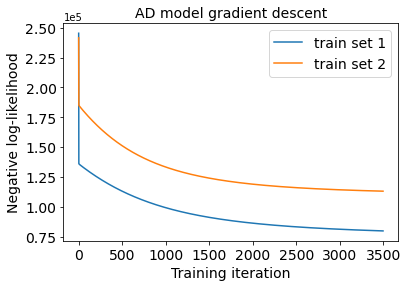

In [89]:
plt.plot(NLLs_1, label = 'train set 1')
plt.plot(NLLs_2, label = 'train set 2')
plt.ylabel('Negative log-likelihood', fontsize=14)
plt.xlabel('Training iteration', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ticklabel_format(axis = 'y', style='sci', scilimits=(0,0))
plt.title('AD model gradient descent', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [90]:
acc, predictions = test_MLE(test, Bs_estimated_2, Bq_estimated_1)
predictions_numpy = predictions.numpy()
predictions_bin = predictions_numpy > 0.5
predictions_bin = torch.tensor(predictions_bin.astype(int))
n_students, n_questions = test.shape[0], test.shape[1]
accuracy = torch.count_nonzero(predictions_bin == test)
print(accuracy / (n_students * n_questions))

tensor(0.8155)


([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

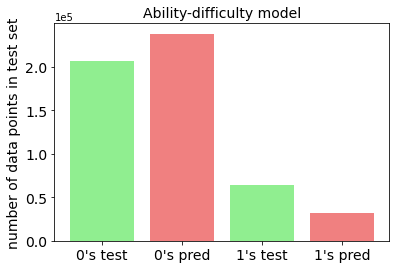

In [108]:
test_zeros = test.shape[0]*test.shape[1] - test.sum()
test_ones = test.sum()

predicted_zeros = predictions_bin.shape[0]*predictions_bin.shape[1] - predictions_bin.sum()
predicted_ones  = predictions_bin.sum()
x = [test_zeros, predicted_zeros, test_ones, predicted_ones]

plt.bar(['0\'s test', '0\'s pred', '1\'s test', '1\'s pred'], height=x,color=['lightgreen','lightcoral','lightgreen','lightcoral'])
plt.title('Ability-difficulty model', fontsize = 14)
plt.ticklabel_format(axis = 'y', style='sci', scilimits=(0,0))
plt.yticks(fontsize=14)
plt.ylabel('number of data points in test set', fontsize=14)
plt.xticks(fontsize=14)

In [106]:
print(test_ones)

tensor(63584., dtype=torch.float64)


In [ ]:
123454.0

In [98]:
data_file = os.path.join(os.getcwd(), 'data', '9to1_2017_GCSE_1H.csv')
df, q_info = import_data(data_file)
shuffle_data(df) 
df = binarise_using_max(df, q_info)

df = convert_df_to_tensor(df)

train_1, train_2, test = separate_train_test_data(df, students_separation_point,
                                                    questions_separation_point)
                                                


/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_data.py:11: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile)


,q6,q23,q4,q7,q24,q21,q3,q18,q19,q17,...,q12,q13,q10,q9,q14,q22,q2,q1,q8,q20
23,2.0,0.0,3.0,3.0,1.0,0.0,1.0,3.0,4.0,0.0,...,1.0,0.0,3.0,2.0,2.0,0.0,2.0,4.0,2.0,0.0
24,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,1.0,3.0,0.0,2.0,0.0,2.0,4.0,1.0,0.0
25,0.0,0.0,0.0,3.0,0.0,0.0,3.0,1.0,4.0,3.0,...,1.0,0.0,3.0,2.0,2.0,0.0,0.0,4.0,0.0,0.0
26,0.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,4.0,0.0,...,1.0,0.0,3.0,2.0,4.0,0.0,1.0,3.0,1.0,0.0
27,0.0,3.0,3.0,3.0,2.0,0.0,3.0,1.0,4.0,3.0,...,1.0,0.0,3.0,2.0,1.0,0.0,2.0,4.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45040,1.0,0.0,3.0,3.0,0.0,0.0,3.0,4.0,0.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,2.0,5.0,3.0,0.0
45041,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,3.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0
45042,1.0,0.0,3.0,3.0,0.0,0.0,3.0,3.0,2.0,3.0,...,0.0,1.0,0.0,2.0,4.0,0.0,2.0,5.0,3.0,0.0
45043,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,...,0.0,0.0,0.0,2.0,2.0,0.0,2.0,5.0,2.0,0.0
